# Looped equation
We try to figure out the looped equation here

In [4]:
# This file implements and tests recursion relations
import numpy as np
import time
import scipy.signal
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

# for importing parsed codes
import sys
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
from recursion_relations import *
import parsed
debug_path = '/Users/lanke/Desktop/Second year project/Code/test_data_eduardo/'

# Profiling
import cProfile
import pstats

Axis shape:


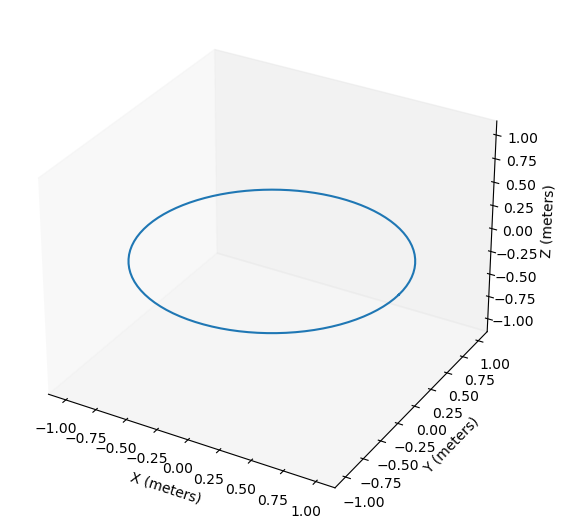

solve_integration_factor: average p_eff: 1.05129704
solve_integration_factor: average f_eff: 0.12055581493791792
integral_mode is spline


In [5]:

phis = np.linspace(0,2*np.pi*999/1000+0j,1000)
# The only case with non-trivial an-isotropic pressure
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )
# B_theta_coef_cp.append(0)
p_perp_coef_cp.append(iterate_p_perp_n(3,
    B_theta_coef_cp,
    B_psi_coef_cp,
    B_alpha_coef,
    B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    iota_coef))
Delta_coef_cp.append(iterate_delta_n(3,
    B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    iota_coef))
test_equilibrium = Equilibrium(X_coef_cp,
    Y_coef_cp,
    Z_coef_cp,
    B_psi_coef_cp,
    B_theta_coef_cp,
    B_denom_coef_c,
    B_alpha_coef,
    kap_p, dl_p, tau_p,
    iota_coef, eta,
    p_perp_coef_cp,
    Delta_coef_cp
    )

$B_{\theta}$ coeffs have 2 components. 
$B_{\theta,n-1}$ has (n-1)+1 - 2(blank) = n-2 components.
In total, number of component of $C \cdot B_{theta,n-1}$ is n-2+2-1 = n-1.
We know that $Y_{n0}, B_{\psi,n0}$ and $B_{\theta,n0}$ all occupy the low m components.
(their coeffs have 1 or 2 modes)
As a result, the higher modes are occupied by $B_{\theta,n-1}$ only.

## Even order
Even order equations solve for $B_{\theta,n-1}$ and $B_{\theta, n0}$. 

Both $B_{\theta, n0}$ components are constant. This means we can remove
the 0th mode element and linear solve for $B_{\theta,n-1}$.

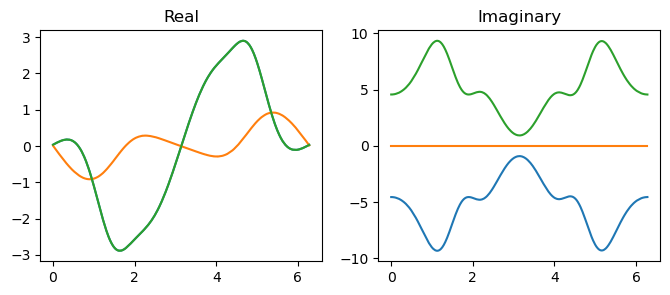

In [6]:
n_eval = 4
loop_suppressing_B_theta_nm1 = parsed.eval_loop(n_eval, \
    X_coef_cp.mask(n_eval-1).zero_append(), Y_coef_cp.mask(n_eval-1).zero_append(), Z_coef_cp.mask(n_eval-1).zero_append(), \
    B_theta_coef_cp.mask(n_eval-2).zero_append().zero_append(), \
    B_psi_coef_cp.mask(n_eval-3).zero_append(),\
    B_alpha_coef, B_denom_coef_c.mask(n_eval-1).zero_append(), \
    p_perp_coef_cp.mask(n_eval-1).zero_append(), \
    Delta_coef_cp.mask(n_eval-1).zero_append(), kap_p, dl_p, tau_p, iota_coef).cap_m(n_eval-2)
loop_suppressing_B_theta_nm1.roll_avg().cap_m(2).display_content(fourier_mode = False)

In [ ]:
# Must be run with Yn-1 and Bpsin-3 with zero center components
# Uses B_theta[n-1]
# Uses a lot of pre-calculated coefficients. 
def iterate_B_psi_nm30_Y_nm10_p(n_eval, \
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    B_theta_coef_cp, B_psi_coef_cp, \
    B_alpha_coef, B_denom_coef_c, \
    p_perp_coef_cp, Delta_coef_cp, \
    kap_p, dl_p, tau_p, iota_coef, \
    test_equilibrium):
    
    if n_eval%2!=1:
        raise AttributeError('iterate_B_psi_nm30_Y_nm10_p: only applicable to even orders.')
    
    loop_no_mask = parsed.eval_loop(n_eval, \
        X_coef_cp.mask(n_eval-1).zero_append(), \
        Y_coef_cp.mask(n_eval-1).zero_append(), \
        Z_coef_cp.mask(n_eval-1).zero_append(), \
        B_theta_coef_cp.mask(n_eval-1).zero_append(), \
        B_psi_coef_cp.mask(n_eval-3).zero_append(),\
        B_alpha_coef, B_denom_coef_c.mask(n_eval-1).zero_append(), \
        p_perp_coef_cp.mask(n_eval-1).zero_append(), \
        Delta_coef_cp.mask(n_eval-1).zero_append(), \
        kap_p, dl_p, tau_p, iota_coef).cap_m(n_eval-2)
    
    len_chi = loop_no_mask.get_shape()[0]
    len_phi = loop_no_mask.get_shape()[1]
    
    # We take the second center component.
    f_raw = loop_no_mask.content[len_chi//2]
    f_eff = test_equilibrium.get_f_eff(f_raw, n_eval)
    
    Y_ppp_coef_n, Y_pp_coef_n, Y_p_coef_n, Y_coef_n = test_equilibrium.get_Yn0_ODE_coeffs(n_eval)
    
    # FFT matrices
    Y_ppp_coef_fft = np.fft.fft(Y_ppp_coef_n)
    Y_pp_coef_fft = np.fft.fft(Y_pp_coef_n)
    Y_p_coef_fft = np.fft.fft(Y_p_coef_n)
    Y_coef_fft = np.fft.fft(Y_coef_n)

    # Of shape [n_chi, n_phi_row, n_phi_col]
    Y_ppp_coef_matrix = fft_conv_op_batch(np.array([Y_ppp_coef_fft]))
    Y_pp_coef_matrix = fft_conv_op_batch(np.array([Y_pp_coef_fft]))
    Y_p_coef_matrix = fft_conv_op_batch(np.array([Y_p_coef_fft]))
    Y_coef_matrix = fft_conv_op_batch(np.array([Y_coef_fft]))

    diff_matrix = fft_dphi_op(len_phi)
    
    linear_diff_op = Y_ppp_coef_matrix@diff_matrix@diff_matrix@diff_matrix\
        +Y_pp_coef_matrix@diff_matrix@diff_matrix\
        +Y_p_coef_matrix@diff_matrix\
        +Y_coef_matrix
    linear_diff_op_inv = np.linalg.inv(linear_diff_op)
    
    Ynm10 = ChiPhiFuncGrid(
        np.fft.ifft(
            (linear_diff_op_inv@np.fft.fft(RHS.content)[:,:,None])[:,:,0]
        )
    )
    
    Bnm30 = test_equilibrium.get_B_psi_nm30(
        y_pp=Ynm10.dphi().dphi().content[0], 
        y_p=Ynm10.dphi().content[0], 
        y=Ynm10.content[0], f_raw=f_raw)
    
    new_Y = Y_coef_cp[n_eval-1].replace_constant(Ynm10)
    new_Bpsi = B_psi_coef_cp[n_eval-3].replace_constant(Bnm30)
    
    return(new_Y, new_Bpsi)

## Prototype for solving $B_{\psi n-3}$ and $Y_{\psi n-1}$
These two vars are given in a pair of coupled 2nd order linear ODE
$Ay'' + By' + Cy + Dz' + Ez = f$
Where $A, B, C, D, E, f$ all have 2 components.
However, the components of $A$ ~ $E$ has a particular form:

$Ay'' + By' + Cy + Dz' + Ez = f$

$A^*y'' + B^*y' + C^*y + D^*z' + E^*z = f^*$

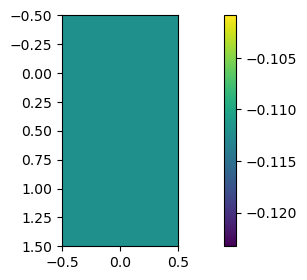

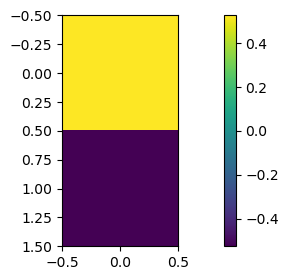

In [13]:

conv_example = conv_matrix(test_equilibrium.coeff_B_theta_nm1.content[:,100], 1)
plt.imshow(np.real(conv_example))
plt.colorbar()
plt.show()
plt.imshow(np.imag(conv_example))
plt.colorbar()
plt.show()

In [14]:
n_eval = 10
# Confirm the shape of coefficients again:
Bcoeff, Bcoeff_dp = test_equilibrium.get_B_psi_nm30_coeffs(n_eval)
Ycoeff, Ycoeff_dp, Ycoeff_dpp = test_equilibrium.get_Y_nm1_coeffs(n_eval)
print('Shapes of coeffs: all of them have 2 chi components.')
print(Bcoeff.get_shape(), Bcoeff_dp.get_shape())
print(Ycoeff.get_shape(), Ycoeff_dp.get_shape(), Ycoeff_dpp.get_shape())

Shapes of coeffs: all of them have 2 chi components.
(2, 1000) (2, 1000)
(2, 1000) (2, 1000) (2, 1000)


In [15]:
c, b, a = Ycoeff.content[1], Ycoeff_dp.content[1], Ycoeff_dpp.content[1]
e, d = Bcoeff.content[1], Bcoeff_dp.content[1]
# f = 

Since a\~e are constants (rather than iterated quantities), 
our solver only need to work well in this a\~e range for all f.

Looks like they're all very small. Let's hope spectral method works.

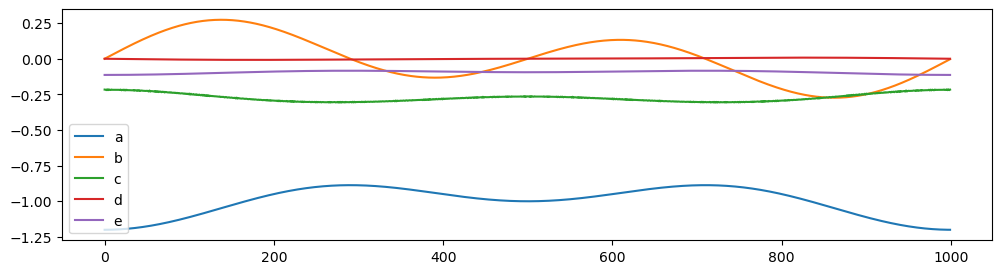

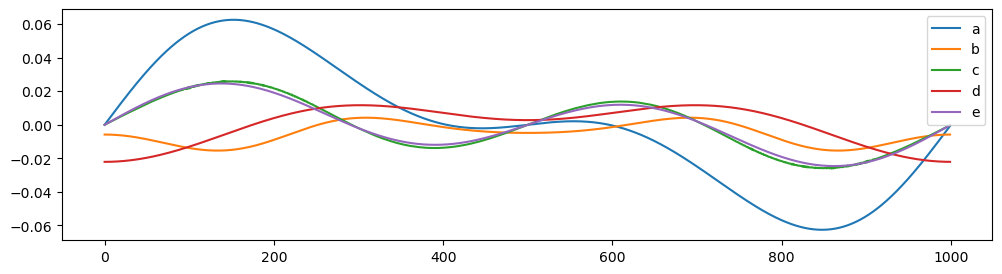

In [16]:
plt.plot(a, label = 'a')
plt.plot(b, label = 'b')
plt.plot(c, label = 'c')
plt.plot(d, label = 'd')
plt.plot(e, label = 'e')
plt.legend()
plt.show()
plt.plot(np.imag(a), label = 'a')
plt.plot(np.imag(b), label = 'b')
plt.plot(np.imag(c), label = 'c')
plt.plot(np.imag(d), label = 'd')
plt.plot(np.imag(e), label = 'e')
plt.legend()

Eliminating Z or Z' doesn't work because $\bar e$ has zeroes.

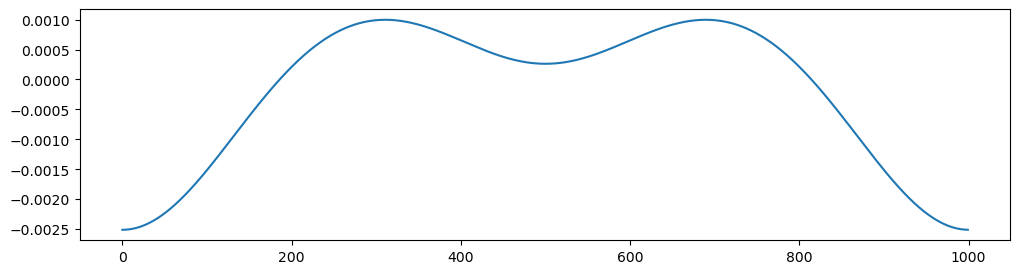

In [17]:
plt.plot(np.imag(e*np.conj(d)))

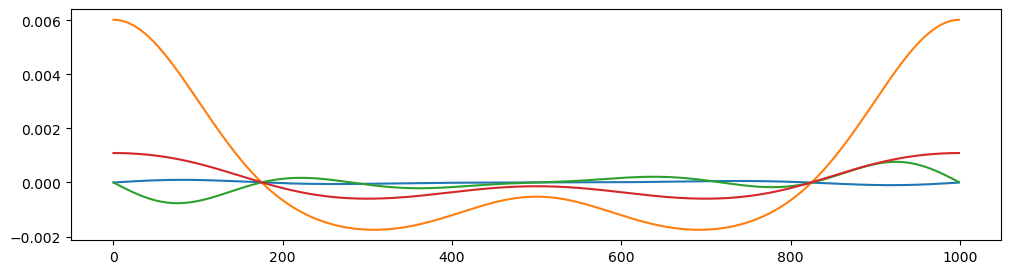

In [26]:
# Eliminating Z' (see paper document)
# ay'' +by' +cy +dz' +ez =f 
# a*y''+b*y'+c*y+d*z'+e*z=f 

# Define a_b is a_bar == Im(ad*), then
# a_b y'' + b_b y' + c_b y - f_b = e_b z 
# (a_b y'' + b_b y' + c_b y - f_b) / e_b = z 
# a_bb y'' + b_bb y' + c_bb y - f_bb = z 
a_b = np.imag(a*np.conj(d))
b_b = np.imag(b*np.conj(d))
c_b = np.imag(c*np.conj(d))
e_b = np.imag(e*np.conj(d))
# f_b = np.imag(f*np.conj(d))

# Not used in the end. Have singularities.
a_bb = a_b/e_b
b_bb = b_b/e_b
c_bb = c_b/e_b
# f_bb = f_b/e_b

y_ppp_coef = a_b * d
y_pp_coef = dphi_direct(np.array([a_b]))[0]*d + b_b*d + a_b*e + a*e_b
y_p_coef = dphi_direct(np.array([b_b]))[0]*d + c_b*d + b_b*e + b*e_b
y_coef = dphi_direct(np.array([c_b]))[0]*d + c_b*e + c*e_b
# f_eff = dphi_direct(np.array([f_b]))*d + f_b*e + f*e_b

y_ppp_coef = low_pass_direct(np.array([y_ppp_coef]))[0]
y_pp_coef = low_pass_direct(np.array([y_pp_coef]))[0]
y_p_coef = low_pass_direct(np.array([y_p_coef]))[0]
y_coef = low_pass_direct(np.array([y_coef]))[0]

plt.plot(y_ppp_coef)
plt.plot(y_pp_coef)
plt.plot(y_p_coef)
plt.plot(y_coef)

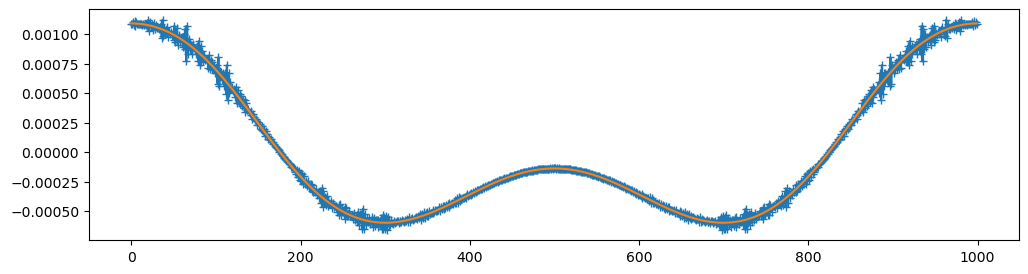

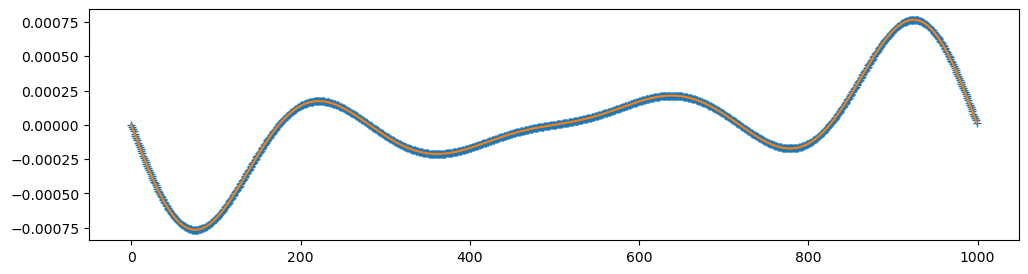

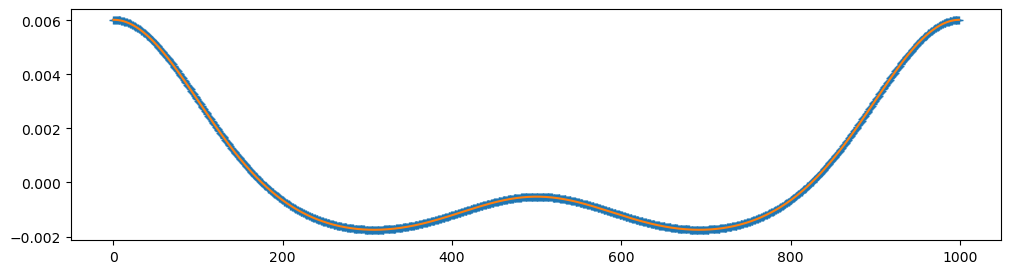

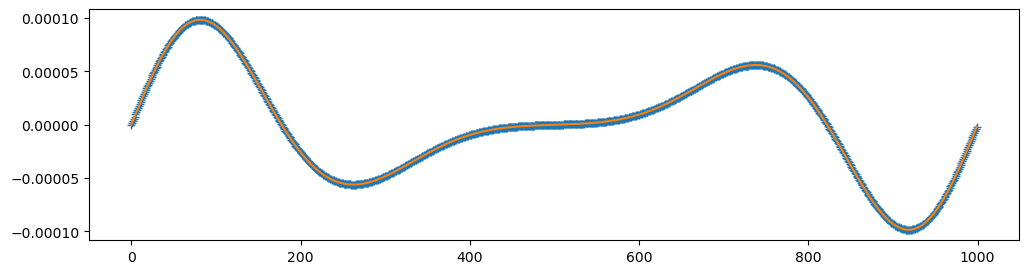

In [27]:
Y_ppp_coef_simp, Y_pp_coef_simp, Y_p_coef_simp, Y_coef_simp = test_equilibrium.get_Yn0_ODE_coeffs(n_eval)

plt.plot(np.real(Y_coef_simp), marker = '+')
plt.plot(np.real(y_coef))
plt.show()
plt.plot(np.real(Y_p_coef_simp), marker = '+')
plt.plot(np.real(y_p_coef))
plt.show()
plt.plot(np.real(Y_pp_coef_simp), marker = '+')
plt.plot(np.real(y_pp_coef))
plt.show()
plt.plot(np.real(Y_ppp_coef_simp), marker = '+')
plt.plot(np.real(y_ppp_coef))
plt.show()

In [ ]:
# FFT matrices
y_ppp_coef_fft = np.fft.fft(y_ppp_coef)
y_pp_coef_fft = np.fft.fft(y_pp_coef)
y_p_coef_fft = np.fft.fft(y_p_coef)
y_coef_fft = np.fft.fft(y_coef)

# Of shape [n_chi, n_phi_row, n_phi_col]
y_ppp_coef_matrix = fft_conv_op_batch(np.array([y_ppp_coef_fft]))
y_pp_coef_matrix = fft_conv_op_batch(np.array([y_pp_coef_fft]))
y_p_coef_matrix = fft_conv_op_batch(np.array([y_p_coef_fft]))
y_coef_matrix = fft_conv_op_batch(np.array([y_coef_fft]))

diff_matrix = fft_dphi_op(len(a_b))

In [ ]:
linear_diff_op = y_ppp_coef_matrix@diff_matrix@diff_matrix@diff_matrix\
    +y_pp_coef_matrix@diff_matrix@diff_matrix\
    +y_p_coef_matrix@diff_matrix\
    +y_coef_matrix

linear_diff_op_inv = np.linalg.inv(linear_diff_op)
print('linear_diff_op_inv', linear_diff_op_inv.shape)

In [ ]:
plt.hist(np.real(linear_diff_op_inv[0]).flatten())
plt.yscale('log')
plt.show()
plt.hist(np.imag(linear_diff_op_inv[0]).flatten())
plt.yscale('log')
plt.show()

In [ ]:
# Creating a random, constant ChiPhiFuncGrid's for testing
rands1 = np.random.randint(10, size=16)
amp = 5
content1 = np.array([
    rands1[0]*amp*np.sin(rands1[1]*points) + rands1[2]*amp*np.cos(rands1[3]*points)
])
test1 = ChiPhiFuncGrid(content1, fourier_mode = True)


In [ ]:
# Testing this forward operator

# testing coeff*dphi*dphi*y
RHS = ChiPhiFuncGrid(np.array([y_ppp_coef]))*test1.dphi().dphi().dphi() + \
    ChiPhiFuncGrid(np.array([y_pp_coef]))*test1.dphi().dphi() + \
    ChiPhiFuncGrid(np.array([y_p_coef]))*test1.dphi()+ \
    ChiPhiFuncGrid(np.array([y_coef]))*test1
    
RHS_by_operator = ChiPhiFuncGrid(
    np.fft.ifft(
        (linear_diff_op@np.fft.fft(test1.content)[:,:,None])[:,:,0]
    )
)

compare_chiphifunc(RHS, RHS_by_operator)

In [ ]:
# Testing inverse operator

y_by_inverse = ChiPhiFuncGrid(
    np.fft.ifft(
        (linear_diff_op_inv@np.fft.fft(RHS.content)[:,:,None])[:,:,0]
    )
)

compare_chiphifunc(test1, y_by_inverse, simple_mode = False)

## Finding the correct way to write down matrix product along axis 1
((y_pp_coef_matrix@diff_matrix@diff_matrix)@np.fft.fft(test1.content)[:,:,None])[:,:,0]

In [ ]:
# diff_matrix[None, :, :] + y_coef_matrix
# Testing diff
test1.dphi().display_content()
ChiPhiFuncGrid(np.fft.ifft((diff_matrix@np.fft.fft(test1.content,axis=1)[:,:,None])[:,:,0])).display_content()

In [ ]:
# Testing coeff*y
(ChiPhiFuncGrid(np.array([y_coef]))*test1).display_content()
ChiPhiFuncGrid(np.fft.ifft((y_coef_matrix@np.fft.fft(test1.content)[:,:,None])[:,:,0])).display_content()

In [ ]:
# testing coeff*dphi*dphi*y

(ChiPhiFuncGrid(np.array([y_pp_coef]))*test1.dphi().dphi()).display_content()
ChiPhiFuncGrid(np.fft.ifft(((y_pp_coef_matrix@diff_matrix@diff_matrix)@np.fft.fft(test1.content)[:,:,None])[:,:,0])).display_content()